<a href="https://colab.research.google.com/github/suresh-venkate/Code_Repositories/blob/main/Deep_Learning/Computer_Vision/Object_Detection/TF_Object_Detection_API/Pretrained_Model_Inference_Only/TF_ObjDet_Inference_Only.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow Object Detection API - Inference Only

This notebook shows how to use the TensorFlow Object Detection API for performing inference on an image using a model pre-trained on the COCO dataset.

# Copy relevant files from GitHub

In [1]:
%%capture

!wget https://raw.githubusercontent.com/suresh-venkate/Code_Repositories//main/Deep_Learning/Computer_Vision/Object_Detection/TF_Object_Detection_API/Pretrained_Model_Inference_Only/coco_ind_label.pkl
!wget https://raw.githubusercontent.com/suresh-venkate/Code_Repositories/main/Deep_Learning/Computer_Vision/Object_Detection/TF_Object_Detection_API/Pretrained_Model_Inference_Only/utils.py
!wget https://raw.githubusercontent.com/suresh-venkate/Code_Repositories/main/Deep_Learning/Computer_Vision/Object_Detection/TF_Object_Detection_API/Pretrained_Model_Inference_Only/Images.zip

!unzip Images.zip

# Import required libraries

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import datetime
import pytz
import time
import os
import tensorflow as tf

from PIL import Image, ImageDraw, ImageFont
from utils import draw_boxes_and_labels

%matplotlib inline

# COCO index to label mapping - Load from disk

In [3]:
fname = "./coco_ind_label.pkl" # Pickle file where index to label mapping of Coco labels are stored
with open(fname, "rb") as file:
    coco_ind_label_dict = pickle.load(file)
    
print(f"Type of coco_ind_label_dict is {type(coco_ind_label_dict)}")
print()
print(f"Keys of coco_ind_label_dict are:")
print("--------------------------------")
print(coco_ind_label_dict.keys())
print()
print("First five elements of coco_ind_label_dict are:")
print("-----------------------------------------------")
for ind in range(1, 6, 1):
    print(coco_ind_label_dict[ind])

Type of coco_ind_label_dict is <class 'dict'>

Keys of coco_ind_label_dict are:
--------------------------------
dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90])

First five elements of coco_ind_label_dict are:
-----------------------------------------------
{'id': 1, 'name': 'person'}
{'id': 2, 'name': 'bicycle'}
{'id': 3, 'name': 'car'}
{'id': 4, 'name': 'motorcycle'}
{'id': 5, 'name': 'airplane'}


# Download and load model

In [4]:
%%capture

### This step is already completed and the model has been saved to disk.
### Will be re-loaded from disk for subsequent runs.

# Download and extract EfficientNet model from TensorFlow model zoo
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d5_coco17_tpu-32.tar.gz    
!tar -xf efficientdet_d5_coco17_tpu-32.tar.gz
!rm efficientdet_d5_coco17_tpu-32.tar.gz

In [5]:
%%capture
# Define path where model is stored
model_path = './efficientdet_d5_coco17_tpu-32/saved_model'
# Load model from path
model = tf.saved_model.load(model_path)

# Load input image

In [6]:
inp_img_path = "./Images/image6.jpg"
inp_img_pil = Image.open(inp_img_path) # Load image as a PIL object
inp_img_arr = np.array(inp_img_pil) # Convert PIL object to numpy array
inp_img_arr = np.expand_dims(inp_img_arr, axis = 0) # Add batch axis
print(f"Shape of inp_img_arr is {inp_img_arr.shape}")

Shape of inp_img_arr is (1, 375, 500, 3)


# Generate output from model

In [7]:
model_out = model(inp_img_arr)

In [8]:
print(f"Type of model_out is {type(model_out)}")
print()
print("Keys of model_out dict are:")
print("---------------------------")
print(model_out.keys())

Type of model_out is <class 'dict'>

Keys of model_out dict are:
---------------------------
dict_keys(['detection_classes', 'num_detections', 'detection_boxes', 'raw_detection_boxes', 'detection_scores', 'raw_detection_scores', 'detection_anchor_indices', 'detection_multiclass_scores'])


# Plot image with BBoxes

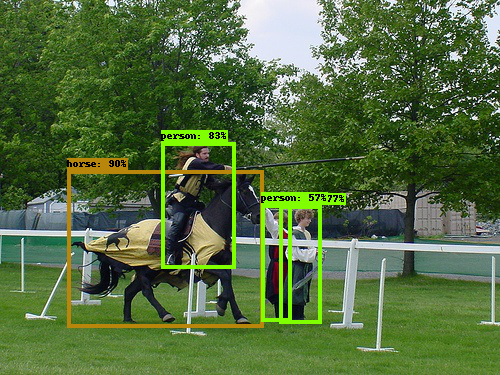

In [9]:
scores = model_out['detection_scores'][0].numpy() # Extract scores for each box
boxes = model_out['detection_boxes'][0].numpy() # Extract box co-ordinates
class_ind = model_out['detection_classes'][0].numpy().astype('int32') # Extract class indices
score_threshold = 0.4 # Boxes with scores below this threshold will be discarded
norm_coords = True # Scale box co-ordinates w.r.t image dimensions
box_thickness = 4 # Thickness to use for drawing BBOX

# Draw box and labels on image
inp_img_pil_w_bbox = draw_boxes_and_labels(inp_img_pil, scores, boxes, class_ind,\
                                           coco_ind_label_dict, score_threshold = 0.4,\
                                           norm_coords = True, box_thickness = 4)
inp_img_pil_w_bbox

# Other Images

In [10]:
def plt_img_w_bboxes(inp_img_path, score_threshold = 0.4, norm_coords = True, box_thickness = 4):
    
    inp_img_pil = Image.open(inp_img_path) # Load image as a PIL object
    inp_img_arr = np.array(inp_img_pil) # Convert PIL object to numpy array
    inp_img_arr = np.expand_dims(inp_img_arr, axis = 0) # Add batch axis
    model_out = model(inp_img_arr) # Pass input image through model
    
    scores = model_out['detection_scores'][0].numpy() # Extract scores for each box
    boxes = model_out['detection_boxes'][0].numpy() # Extract box co-ordinates
    class_ind = model_out['detection_classes'][0].numpy().astype('int32') # Extract class indices
    
    # Draw box and labels on image
    inp_img_pil_w_bbox = draw_boxes_and_labels(inp_img_pil, scores, boxes, class_ind,\
                                               coco_ind_label_dict,\
                                               score_threshold = score_threshold,\
                                               norm_coords = norm_coords,\
                                               box_thickness = box_thickness)
    
    return inp_img_pil_w_bbox

## Image 1

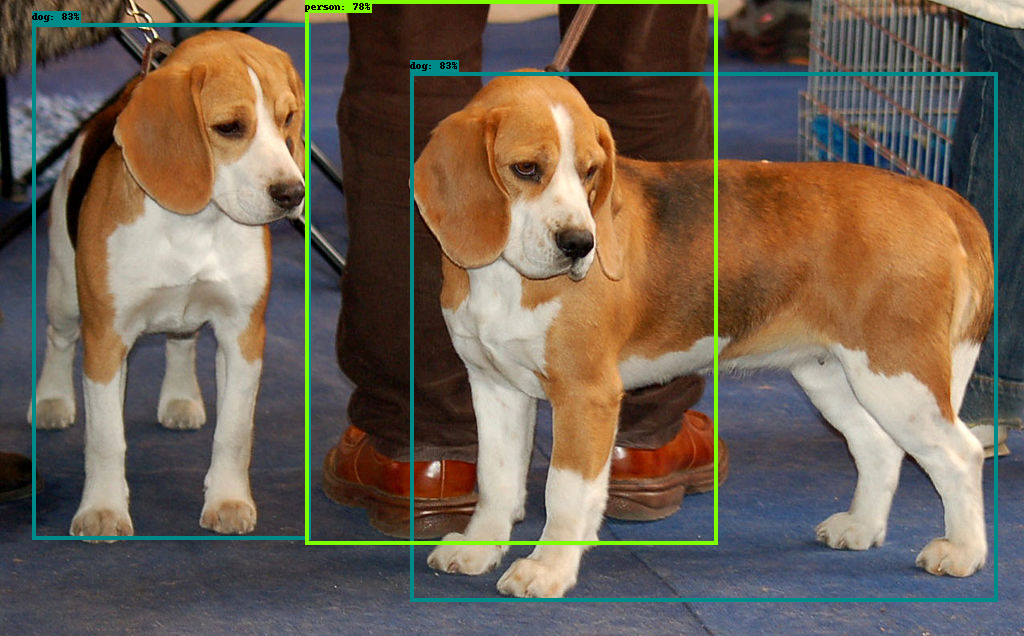

In [11]:
inp_img_path = "./Images/image1.jpg"
plt_img_w_bboxes(inp_img_path)

## Image 2

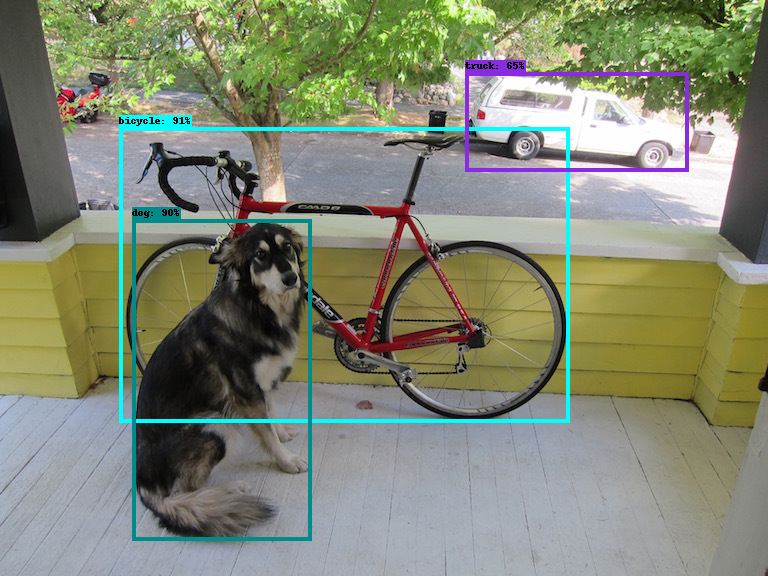

In [12]:
inp_img_path = "./Images/image2.jpg"
plt_img_w_bboxes(inp_img_path)

# Other Models

In [ ]:
#%%capture

### This step is already completed and the model has been saved to disk.
### Will be re-loaded from disk for subsequent runs.

# # Download and extract EfficientNet model from TensorFlow model zoo
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_1024x1024_coco17_tpu-8.tar.gz
!tar -xf ssd_resnet50_v1_fpn_1024x1024_coco17_tpu-8.tar.gz --directory C:/User_Directories/Sync_With_NAS/Users/suresh/work/Model_Zoo/TF_Models/SSD_resnet50_v1_1024x1024/
!del efficientdet_d5_coco17_tpu-32.tar.gz

In [ ]:
%%capture
# Define path where model is stored
model_path = os.path.normpath(r'C:\User_Directories\Sync_With_NAS\Users\suresh\work\Model_Zoo\TF_Models\SSD_resnet50_v1_1024x1024\ssd_resnet50_v1_fpn_1024x1024_coco17_tpu-8\saved_model')
# Load model from path
model = tf.saved_model.load(model_path)

In [ ]:
infer = model.signatures['serving_default']

In [ ]:
inp_img_path = "./Images/image2.jpg"
plt_img_w_bboxes(inp_img_path)